# Dataset Visualisation
This file is just for the purpose of visualising the data before doing anything else. We will explore the dataset in this jupiter notebooks

🧠 **Goals of Exploration**:

1. Understand how the MRI modalities look (FLAIR, T1, T1ce, T2)
2. Understand the tumor anatomy + segmentation labels
3. Check for inconsistencies, missing modalities, and overall structure
4. Get comfortable with visualizing 3D medical data

## **Basic Terminology:**

### **1. Voxel**
    A voxel = "volume pixel". The smallest unit of a 3D image (like a pixel in 2D). An MRI scan is made of voxels arranged in a 3D grid:
    width × height × depth

### **2. MRI modalities**

| Modality | Full Name            | What it Highlights                |
| -------- | -------------------- | --------------------------------- |
| `T1n`    | T1-weighted (native) | Brain structure                   |
| `T1ce`   | T1 contrast-enhanced | Enhancing tumor core (after dye)  |
| `T2f`    | T2-FLAIR             | Edema (swelling) around the tumor |
| `T2w`    | T2-weighted          | General fluid content + tissue    |

Each of these MRI modalities is a different “view” or contrast of the same brain scan, designed to highlight different tissue characteristics. It is much like using different filters on the same photo to reveal different details.

*Analogy:*

*Imagine shining:*

*    *A red light to highlight blood,*
*    *A UV light to show scratches,*
*    *A blue light to make edges pop.*

*All on the same object but each reveals something different.*

### **3. Segmentation Mask**
A 3D image where each voxel has a label:

* 0 = background
* 1 = non-enhancing tumor core
* 2 = peritumoral edema
* 4 = enhancing tumor core

Used as ground truth for training your model

### **4. Tumour sub-regions**

#### 1. Enhancing Tumor (ET)
**Label: 4**

Description:
This region corresponds to the part of the tumor that actively absorbs contrast agent, indicating aggressive growth and breakdown of the blood-brain barrier. It appears bright on the T1CE modality and is a primary target in surgical and radiation planning.

#### 2. Non-Enhancing Tumor Core (NETC)
**Label: 1**

Description:
This includes the tumor core that does not enhance with contrast. It may represent necrotic (dead) tissue or infiltrative tumor that is not actively growing. It typically appears dark or gray on T1CE and T2 modalities and is surrounded by other tumor or edema regions.

#### 3. Surrounding Non-Enhancing FLAIR Hyperintensity (SNFH)
**Label: 2**

Description:
This region captures the swelling (edema) or abnormal fluid accumulation in the brain tissue surrounding the tumor. It does not enhance with contrast and appears hyperintense (bright) on the T2-FLAIR modality. It helps indicate the extent of tumor influence beyond the core.


| Region Name                             | Label | Best Seen In | Description                                 |
| --------------------------------------- | ----- | ------------ | ------------------------------------------- |
| Enhancing Tumor (ET)                    | 4     | T1CE         | Actively growing, contrast-enhancing region |
| Non-Enhancing Tumor Core (NETC)         | 1     | T1 / T2      | Necrotic or inactive tumor core             |
| Surrounding FLAIR Hyperintensity (SNFH) | 2     | T2-FLAIR     | Edema or tissue reaction around the tumor   |


**Color-to-Label Mapping:**
| Color                      | Likely Label | Meaning                                         |
| -------------------------- | ------------ | ----------------------------------------------- |
| **Dark Blue / Background** | 0            | Healthy brain tissue (non-tumor)                |
| **Yellow**                 | 2            | Surrounding edema (SNFH / FLAIR hyperintensity) |
| **Brown-Red**              | 1            | Non-enhancing tumor core (NETC)                 |
| **Light Blue / Cyan**      | 4            | Enhancing tumor core (ET)                       |


### **5. Slice**
A 2D cross-section of the 3D MRI volume. You can slice in 3 ways:

* Axial (top-down)
* Coronal (front view)
* Sagittal (side view)

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
import napari
from scipy.ndimage import find_objects

### Single sample visualisation

In [2]:
sample_id = "BraTS-SSA-00008-000"
sample_path = f"./dataset/extracted_training_set/{sample_id}"

t1n = nib.load(f"{sample_path}/t1n.nii.gz").get_fdata()
t1ce = nib.load(f"{sample_path}/t1ce.nii.gz").get_fdata()
t2f = nib.load(f"{sample_path}/t2f.nii.gz").get_fdata()
t2w = nib.load(f"{sample_path}/t2w.nii.gz").get_fdata()
seg = nib.load(f"{sample_path}/seg.nii.gz").get_fdata()


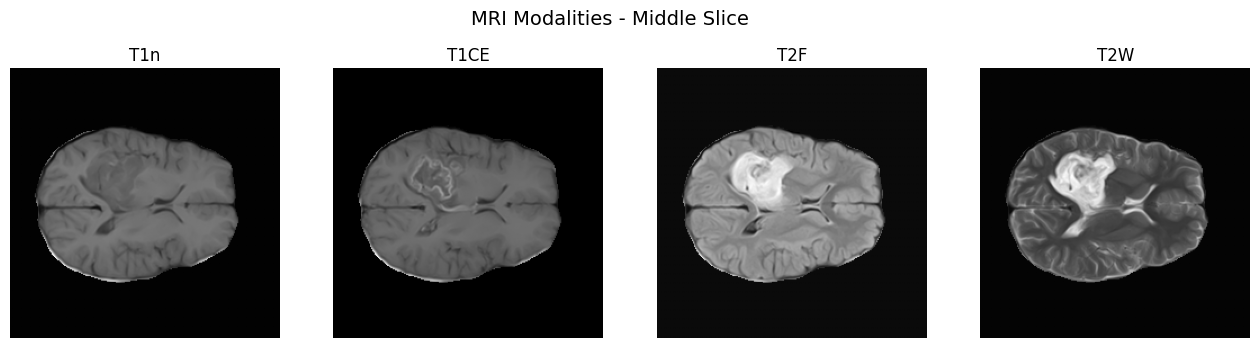

In [3]:
z = t1n.shape[2] // 2  # middle axial slice

modalities = {"T1n": t1n, "T1CE": t1ce, "T2F": t2f, "T2W": t2w}
plt.figure(figsize=(16, 4))
for i, (modality, image) in enumerate(modalities.items()):
    plt.subplot(1, 4, i+1)
    plt.imshow(image[:, :, z], cmap='gray')
    plt.title(modality)
    plt.axis("off")
plt.suptitle("MRI Modalities - Middle Slice", fontsize=14)
plt.show()


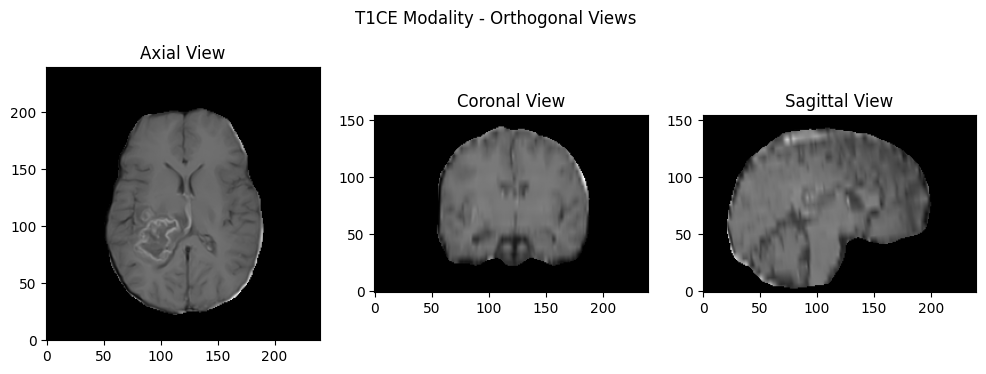

In [4]:
slice_axial = t1ce[:, :, t1ce.shape[2] // 2]     # Axial (top-down)
slice_coronal = t1ce[:, t1ce.shape[1] // 2, :]   # Coronal (front-facing)
slice_sagittal = t1ce[t1ce.shape[0] // 2, :, :]  # Sagittal (side-view)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(slice_axial.T, cmap='gray', origin='lower')
plt.title("Axial View")

plt.subplot(1, 3, 2)
plt.imshow(slice_coronal.T, cmap='gray', origin='lower')
plt.title("Coronal View")

plt.subplot(1, 3, 3)
plt.imshow(slice_sagittal.T, cmap='gray', origin='lower')
plt.title("Sagittal View")

plt.suptitle("T1CE Modality - Orthogonal Views")
plt.show()


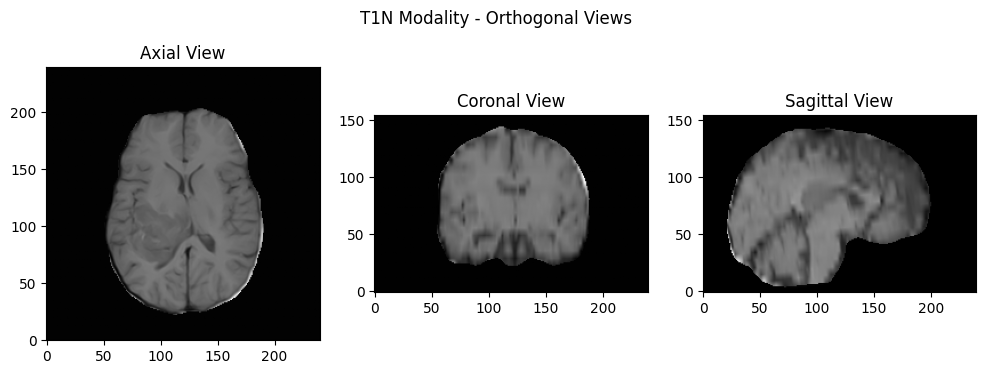

In [24]:
slice_axial = t1n[:, :, t1n.shape[2] // 2]     # Axial (top-down)
slice_coronal = t1n[:, t1n.shape[1] // 2, :]   # Coronal (front-facing)
slice_sagittal = t1n[t1n.shape[0] // 2, :, :]  # Sagittal (side-view)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(slice_axial.T, cmap='gray', origin='lower')
plt.title("Axial View")

plt.subplot(1, 3, 2)
plt.imshow(slice_coronal.T, cmap='gray', origin='lower')
plt.title("Coronal View")

plt.subplot(1, 3, 3)
plt.imshow(slice_sagittal.T, cmap='gray', origin='lower')
plt.title("Sagittal View")

plt.suptitle("T1N Modality - Orthogonal Views")
plt.show()

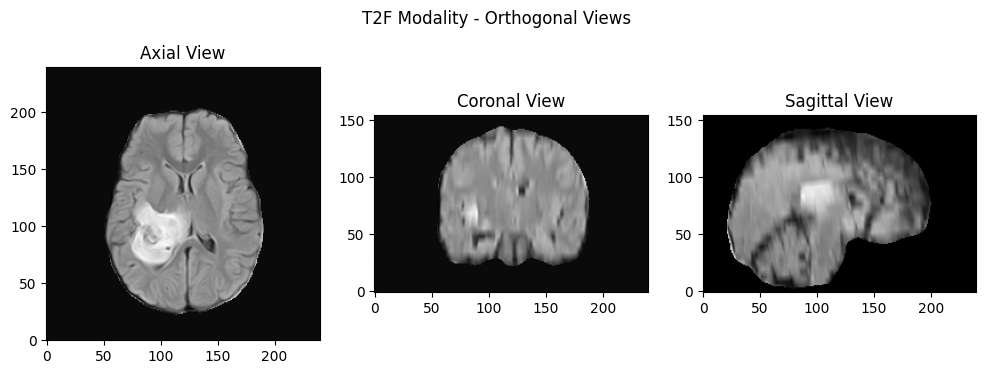

In [ ]:
slice_axial = t2f[:, :, t2f.shape[2] // 2]     # Axial (top-down)
slice_coronal = t2f[:, t2f.shape[1] // 2, :]   # Coronal (front-facing)
slice_sagittal = t2f[t2f.shape[0] // 2, :, :]  # Sagittal (side-view)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(slice_axial.T, cmap='gray', origin='lower')
plt.title("Axial View")

plt.subplot(1, 3, 2)
plt.imshow(slice_coronal.T, cmap='gray', origin='lower')
plt.title("Coronal View")

plt.subplot(1, 3, 3)
plt.imshow(slice_sagittal.T, cmap='gray', origin='lower')
plt.title("Sagittal View")

plt.suptitle("T2F Modality - Orthogonal Views")
plt.show()

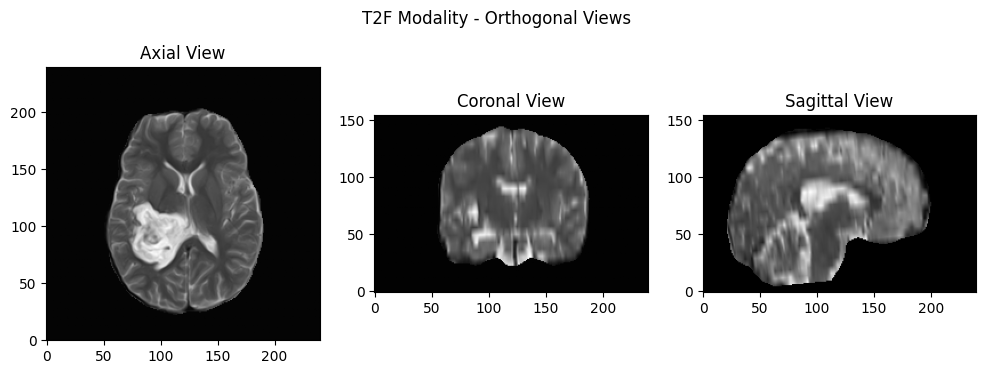

In [26]:
slice_axial = t2w[:, :, t2w.shape[2] // 2]     # Axial (top-down)
slice_coronal = t2w[:, t2w.shape[1] // 2, :]   # Coronal (front-facing)
slice_sagittal = t2w[t2w.shape[0] // 2, :, :]  # Sagittal (side-view)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(slice_axial.T, cmap='gray', origin='lower')
plt.title("Axial View")

plt.subplot(1, 3, 2)
plt.imshow(slice_coronal.T, cmap='gray', origin='lower')
plt.title("Coronal View")

plt.subplot(1, 3, 3)
plt.imshow(slice_sagittal.T, cmap='gray', origin='lower')
plt.title("Sagittal View")

plt.suptitle("T2F Modality - Orthogonal Views")
plt.show()

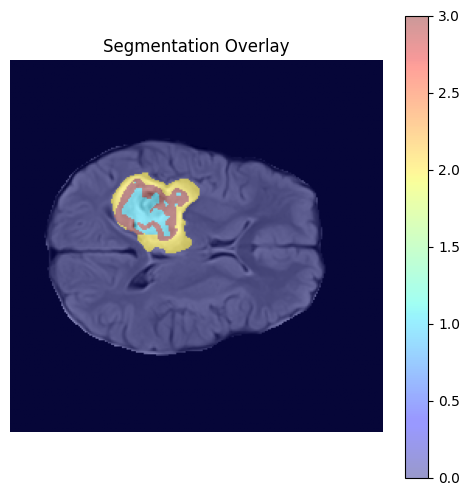

In [5]:
plt.figure(figsize=(6, 6))
plt.imshow(t2f[:, :, z], cmap='gray')
plt.imshow(seg[:, :, z], cmap='jet', alpha=0.4)
plt.title("Segmentation Overlay")
plt.axis("off")
plt.colorbar()
plt.show()


In [6]:
unique, counts = np.unique(seg, return_counts=True)
label_map = {0: "Background", 1: "Tumor Core", 2: "Edema", 4: "Enhancing Tumor"}

print("Label Breakdown:")
for u, c in zip(unique, counts):
    print(f"Label {int(u)} ({label_map.get(int(u), 'Unknown')}): {c} voxels")


Label Breakdown:
Label 0 (Background): 8834708 voxels
Label 1 (Tumor Core): 19333 voxels
Label 2 (Edema): 47943 voxels
Label 3 (Unknown): 26016 voxels


In [7]:
data_root = "./dataset/extracted_training_set"
case_dirs = os.listdir(data_root)

for case in sorted(case_dirs):
    seg_path = os.path.join(data_root, case, "seg.nii.gz")
    if os.path.exists(seg_path):
        seg = nib.load(seg_path).get_fdata()
        voxels = np.count_nonzero(seg)
        print(f"{case}: tumor voxels = {voxels}")
    else:
        print(f"{case}: segmentation missing")


BraTS-SSA-00002-000: tumor voxels = 218461
BraTS-SSA-00007-000: tumor voxels = 295774
BraTS-SSA-00008-000: tumor voxels = 93292
BraTS-SSA-00010-000: tumor voxels = 163613
BraTS-SSA-00011-000: tumor voxels = 207545
BraTS-SSA-00012-000: tumor voxels = 149888
BraTS-SSA-00014-000: tumor voxels = 120281
BraTS-SSA-00015-000: tumor voxels = 394409
BraTS-SSA-00025-000: tumor voxels = 255772
BraTS-SSA-00026-000: tumor voxels = 124188
BraTS-SSA-00028-000: tumor voxels = 168773
BraTS-SSA-00037-000: tumor voxels = 31855
BraTS-SSA-00041-000: tumor voxels = 62289
BraTS-SSA-00044-000: tumor voxels = 163885
BraTS-SSA-00046-000: tumor voxels = 64448
BraTS-SSA-00047-000: tumor voxels = 22418
BraTS-SSA-00049-000: tumor voxels = 103415
BraTS-SSA-00050-000: tumor voxels = 108197
BraTS-SSA-00051-000: tumor voxels = 92559
BraTS-SSA-00055-000: tumor voxels = 162691
BraTS-SSA-00056-000: tumor voxels = 164288
BraTS-SSA-00057-000: tumor voxels = 316684
BraTS-SSA-00068-000: tumor voxels = 52399
BraTS-SSA-00074-00

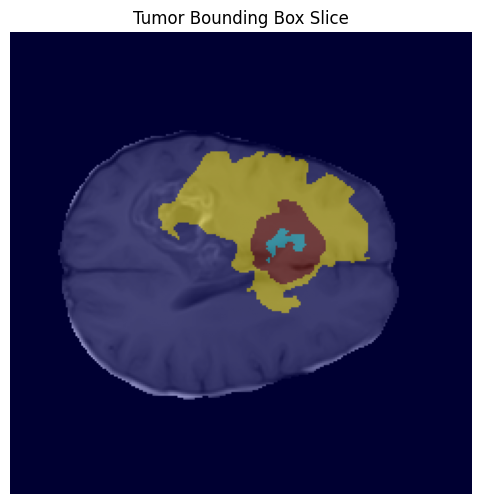

In [ ]:
bbox = find_objects(seg > 0)[0]
z_mid = (bbox[2].start + bbox[2].stop) // 2

plt.figure(figsize=(6, 6))
plt.imshow(t1ce[:, :, z_mid], cmap='gray')
plt.imshow(seg[:, :, z_mid], cmap='jet', alpha=0.4)
plt.title("Tumor Bounding Box Slice")
plt.axis("off")
plt.show()


In [9]:
# Path to your extracted training set
root_path = "./dataset/extracted_training_set"

# For each case, load segmentation mask and count tumor voxels
case_stats = []

for case in sorted(os.listdir(root_path)):
    case_path = os.path.join(root_path, case)
    seg_path = os.path.join(case_path, "seg.nii.gz")

    if not os.path.exists(seg_path):
        print(f"❌ Missing segmentation for: {case}")
        continue

    try:
        seg = nib.load(seg_path).get_fdata()
        tumor_voxels = np.count_nonzero(seg)
        label_set = np.unique(seg)
        case_stats.append((case, tumor_voxels, label_set))
        print(f"✅ {case}: tumor voxels = {tumor_voxels}, labels = {label_set}")
    except Exception as e:
        print(f"❌ Error in {case}: {e}")

✅ BraTS-SSA-00002-000: tumor voxels = 218461, labels = [0. 1. 2. 3.]
✅ BraTS-SSA-00007-000: tumor voxels = 295774, labels = [0. 1. 2. 3.]
✅ BraTS-SSA-00008-000: tumor voxels = 93292, labels = [0. 1. 2. 3.]
✅ BraTS-SSA-00010-000: tumor voxels = 163613, labels = [0. 1. 2. 3.]
✅ BraTS-SSA-00011-000: tumor voxels = 207545, labels = [0. 1. 2. 3.]
✅ BraTS-SSA-00012-000: tumor voxels = 149888, labels = [0. 1. 2. 3.]
✅ BraTS-SSA-00014-000: tumor voxels = 120281, labels = [0. 1. 2. 3.]
✅ BraTS-SSA-00015-000: tumor voxels = 394409, labels = [0. 1. 2. 3.]
✅ BraTS-SSA-00025-000: tumor voxels = 255772, labels = [0. 1. 2. 3.]
✅ BraTS-SSA-00026-000: tumor voxels = 124188, labels = [0. 1. 2. 3.]
✅ BraTS-SSA-00028-000: tumor voxels = 168773, labels = [0. 1. 2. 3.]
✅ BraTS-SSA-00037-000: tumor voxels = 31855, labels = [0. 1. 2. 3.]
✅ BraTS-SSA-00041-000: tumor voxels = 62289, labels = [0. 1. 2. 3.]
✅ BraTS-SSA-00044-000: tumor voxels = 163885, labels = [0. 1. 2. 3.]
✅ BraTS-SSA-00046-000: tumor voxels =

In [10]:
# Summary stats
tumor_voxels_all = [vox for _, vox, _ in case_stats]
print(f"\n Total cases analyzed: {len(case_stats)}")
print(f" Average tumor voxels: {np.mean(tumor_voxels_all):.2f}")
print(f" Min tumor voxels: {np.min(tumor_voxels_all)}")
print(f" Max tumor voxels: {np.max(tumor_voxels_all)}")



 Total cases analyzed: 60
 Average tumor voxels: 161361.25
 Min tumor voxels: 1026
 Max tumor voxels: 394409


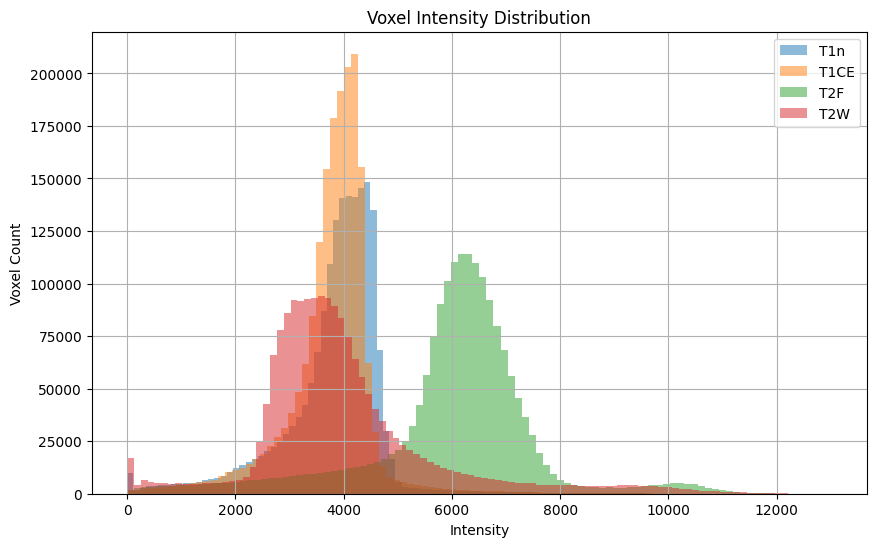

In [11]:
plt.figure(figsize=(10, 6))
for name, volume in modalities.items():
    flattened = volume.flatten()
    flattened = flattened[flattened > 0]  # ignore background
    plt.hist(flattened, bins=100, alpha=0.5, label=name)

plt.title("Voxel Intensity Distribution")
plt.xlabel("Intensity")
plt.ylabel("Voxel Count")
plt.legend()
plt.grid(True)
plt.show()


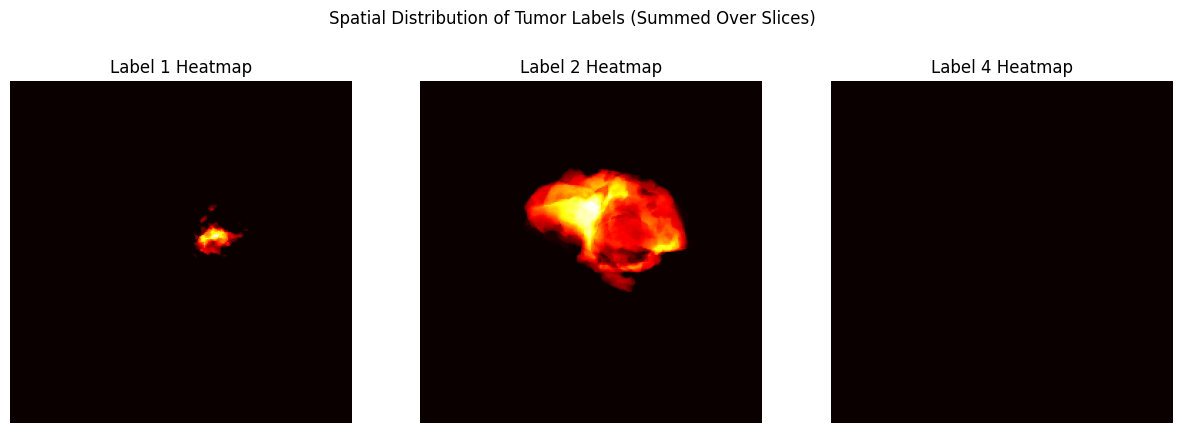

In [12]:
labels = [1, 2, 4]
fig, axes = plt.subplots(1, len(labels), figsize=(15, 5))

for i, label in enumerate(labels):
    label_mask = (seg == label).astype(np.uint8)
    heatmap = np.sum(label_mask, axis=2)  # collapse z-axis

    axes[i].imshow(heatmap, cmap='hot')
    axes[i].set_title(f"Label {label} Heatmap")
    axes[i].axis("off")

plt.suptitle("Spatial Distribution of Tumor Labels (Summed Over Slices)")
plt.show()


In [ ]:
def view_slice(z):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(t2f[:, :, z], cmap="gray")
    ax.imshow(seg[:, :, z], cmap="jet", alpha=0.4)
    ax.set_title(f"Slice {z}")
    ax.axis("off")
    plt.show()

slider = widgets.IntSlider(min=0, max=t2f.shape[2]-1, step=1, value=t2f.shape[2]//2)
widgets.interact(view_slice, z=slider)


interactive(children=(IntSlider(value=77, description='z', max=154), Output()), _dom_classes=('widget-interact…

<function __main__.view_slice(z)>

In [21]:
%gui qt

In [ ]:
# Convert segmentation mask to integer type
seg_int = seg.astype(np.uint8)

viewer = napari.view_image(t1ce, name='T1CE')
viewer.add_labels(seg_int, name='Segmentation')


<Labels layer 'Segmentation' at 0x1ef12b5b7f0>

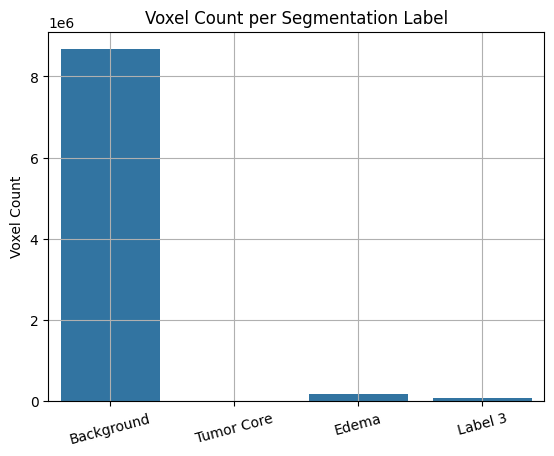

In [ ]:
labels, counts = np.unique(seg, return_counts=True)
label_names = {0: "Background", 1: "Tumor Core", 2: "Edema", 4: "Enhancing Tumor"}
mapped_labels = [label_names.get(int(l), f"Label {int(l)}") for l in labels]

sns.barplot(x=mapped_labels, y=counts)
plt.title("Voxel Count per Segmentation Label")
plt.ylabel("Voxel Count")
plt.xticks(rotation=15)
plt.grid(True)
plt.show()
